# Getting Started With PyTorch

[PyTorch](http://pytorch.org/) is a framework for building and training neural networks. It behaves a lot like Numpy arrays, which after all, are just tensors.

*Tensors* are a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices (RGB color images for example) is a 3-dimensional tensor. The fundamental data structure for neural networks are tensors, and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.

In [1]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    
def tensor_imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [2]:
import torch

In [6]:
### Generate some data
torch.manual_seed(7) # Set the random seed so things are predictable

# Features are 5 random normal variables
# create a tensor of random normal vars
# we give it a tuple of the size of tensor we want: row X column
features = torch.randn((1, 5)) 
features

# True weights for our data, random normal variables again
# create a tensor of random variables with the same shape as features
weights = torch.randn_like(features)
weights

# and a true bias term
bias = torch.randn((1, 1))
bias

# we can use these weights and features to calculate the output of a potential neural network:
torch.sum(torch.matmul(features, weights.view(5, 1)) + bias)

tensor([[-0.1468,  0.7861,  0.9468, -1.1143,  1.6908]])

tensor([[-0.8948, -0.3556,  1.2324,  0.1382, -1.6822]])

tensor([[0.3177]])

tensor(-1.6619)

### Explanation

`features = torch.randn((1, 5))` creates a tensor with shape `(1, 5)`, one row and five columns, that contains values randomly distributed according to the normal distribution with a mean of zero and standard deviation of one. 

`weights = torch.randn_like(features)` creates another tensor with the same shape as `features`, again containing values from a normal distribution.

`bias = torch.randn((1, 1))` creates a single value from a normal distribution.

`torch.mm()` this should be used for matrix/vector multiplication instead of `*` because it is optimized by PyTorch.

When we use `torch.mm()`, the matricies we are multiplying need to be of appropriate dimensions. To ensure this, we can use one of the funcitons below:

* `weights.reshape(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)` sometimes, and sometimes a clone, as in it copies the data to another part of memory.
* `weights.resize_(a, b)` returns the same tensor with a different shape. However, if the new shape results in fewer elements than the original tensor, some elements will be removed from the tensor (but not from memory). If the new shape results in more elements than the original tensor, new elements will be uninitialized in memory. * `weights.view(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)`.

Note that the underscore at the end of the method denotes that this method is performed **in-place**. Here is a great forum thread to [read more about in-place operations](https://discuss.pytorch.org/t/what-is-in-place-operation/16244) in PyTorch.

## Numpy and Torch

Pytorch makes it easy to switch between Numpy arrays and tensors. To create a tensor from a Numpy array, use `torch.from_numpy()` method. To convert a tensor to a Numpy array, use the `.numpy()` method.

In [18]:
import numpy as np
a = np.random.rand(2,2)
a

b = torch.from_numpy(a)
b

b.numpy()

b.mul_(2) # multiple each element by 2. recall that the _ means "in-place"

a # multiplication is reflected in the original numpy array, because the memory is shared

array([[0.38758316, 0.16591224],
       [0.27816011, 0.27528984]])

tensor([[0.3876, 0.1659],
        [0.2782, 0.2753]], dtype=torch.float64)

array([[0.38758316, 0.16591224],
       [0.27816011, 0.27528984]])


 Multiple each element by 2


tensor([[0.7752, 0.3318],
        [0.5563, 0.5506]], dtype=torch.float64)


 Multiplication is reflected in the original numpy array, because the memory is shared


array([[0.77516631, 0.33182448],
       [0.55632021, 0.55057968]])

# Neural networks with PyTorch

In [45]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt

### Downloading and Visualizing MNIST

In [33]:
from torchvision import datasets, transforms

# Define a transform to normalize the data -- dont really unnderstand this part
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# gives us back an object we call trainloader, which we 
# can turn into a generator

Now we have the MNIST data loaded into `trainloader`. We can make this into an iterator by using `iter(trainloader)`.

The `batch_size` specifies the number of images we get from 1 iteration. `shuffle = True` means that at every iteration we shuffle the dataset.

In [34]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


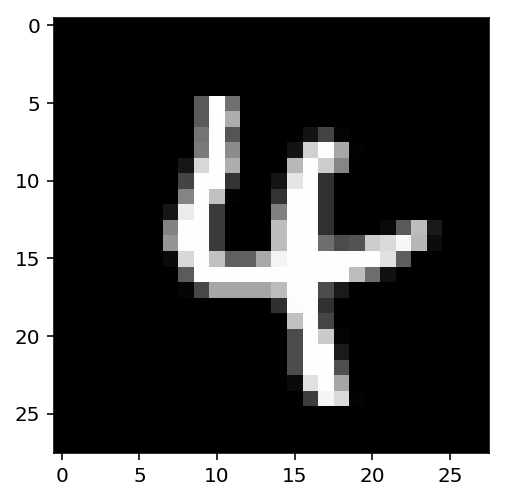

In [35]:
# squeeze removes the 3rd dimension of the image (which i think is the channels)
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

### Building Neural Networks

In [36]:
from torch import nn
import torch.nn.functional as F

class Network (nn.Module) :
    def __init__ (self) :
        super().__init__()
        self.fc1 = nn.Linear(784, 128) # 784 input nodes and 128 output nodes
        self.fc2 = nn.Linear(128, 64) # 128 input nodes and 64 output nodes
        self.output = nn.Linear(64, 10) # 64 input nodes and 10 output nodes
        
    # netowrks defined with nn.Module must have a forward method
    def forward (self, x) :
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.softmax(self.output(x))

```python
class Network(nn.Module):
```

We're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. 

```python
self.fc1 = nn.Linear(784, 128) # 784 input nodes and 128 output nodes
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.fc1`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = F.sigmoid(self.fc1(x))
x = F.sigmoid(self.fc2(x))
x = F.softmax(self.output(x))        
```

The input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

In [37]:
m = Network()
m

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [38]:
print(m.fc1.weight)
print(m.fc1.bias)

Parameter containing:
tensor([[-0.0152, -0.0196, -0.0268,  ...,  0.0059,  0.0146,  0.0199],
        [-0.0051, -0.0326, -0.0281,  ..., -0.0105, -0.0208, -0.0231],
        [-0.0157,  0.0221, -0.0138,  ...,  0.0193, -0.0055, -0.0145],
        ...,
        [-0.0052, -0.0170, -0.0014,  ..., -0.0193,  0.0301, -0.0314],
        [ 0.0086,  0.0212,  0.0279,  ...,  0.0296, -0.0081, -0.0238],
        [ 0.0214, -0.0162, -0.0343,  ..., -0.0276, -0.0041,  0.0337]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0111, -0.0167, -0.0031,  0.0275, -0.0233,  0.0055, -0.0203, -0.0290,
         0.0173,  0.0308,  0.0347,  0.0286,  0.0076,  0.0080, -0.0092, -0.0342,
         0.0199,  0.0001,  0.0202, -0.0087, -0.0301, -0.0172,  0.0287, -0.0242,
        -0.0262,  0.0276,  0.0327,  0.0243,  0.0286,  0.0209, -0.0182,  0.0029,
         0.0269, -0.0088,  0.0107, -0.0215, -0.0254,  0.0228, -0.0155,  0.0215,
         0.0329, -0.0315, -0.0285,  0.0285, -0.0006, -0.0253,  0.0058,  0.0111,
        -0.0261

### Forward Pass

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        ...,

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]]])

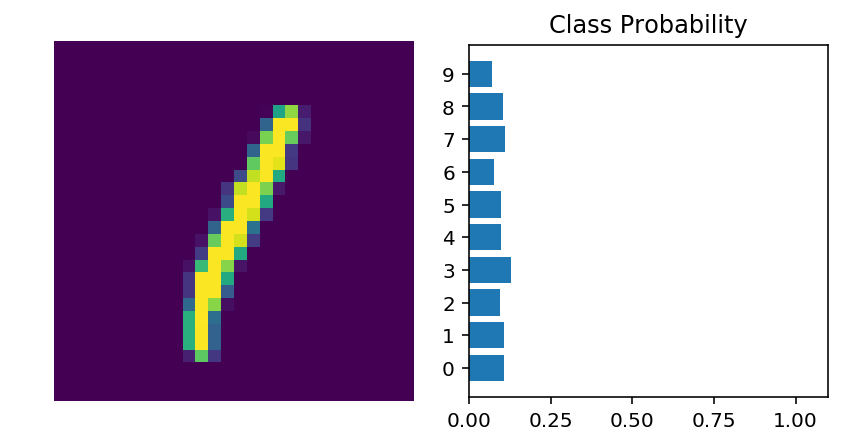

In [46]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

#### Building Networks With `nn.Sequential`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


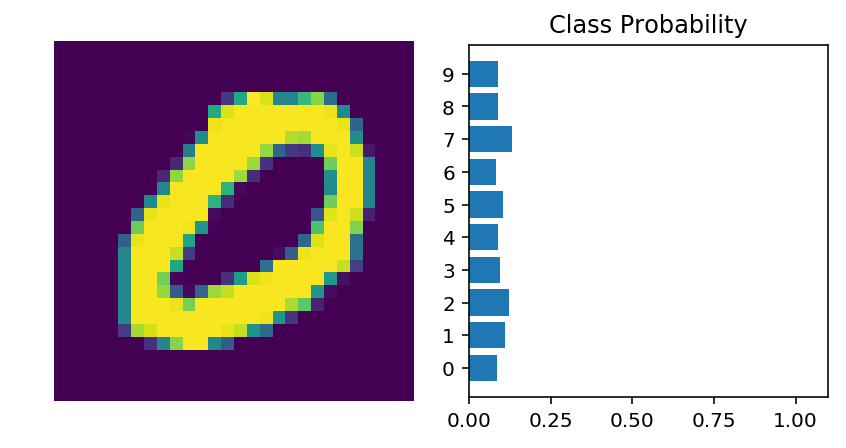

In [51]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
_ = images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

The operations are available by passing in the appropriate index. For example, if you want to get first Linear operation and look at the weights, you'd use `model[0]`.

In [48]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[-0.0355, -0.0252,  0.0079,  ...,  0.0029, -0.0052,  0.0347],
        [-0.0045, -0.0102, -0.0125,  ..., -0.0352, -0.0173,  0.0224],
        [-0.0133,  0.0264, -0.0125,  ...,  0.0046,  0.0241,  0.0352],
        ...,
        [ 0.0007, -0.0295,  0.0203,  ..., -0.0206,  0.0338,  0.0220],
        [ 0.0116,  0.0110, -0.0038,  ...,  0.0067,  0.0064,  0.0289],
        [ 0.0344,  0.0223,  0.0204,  ...,  0.0207, -0.0223,  0.0351]],
       requires_grad=True)

You can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

In [49]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Now we can access the layers by integer or by name

In [50]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


### Loss Functions

We'll start by looking at the [cross entropy loss](http://neuralnetworksanddeeplearning.com/chap3.html#what_does_the_cross-entropy_mean_where_does_it_come_from), defined in the `nn` module as `nn.CrossEntropyLoss` (when using [SoftMax](http://neuralnetworksanddeeplearning.com/chap3.html#softmax) in the output layer, we want to use cross entropy as the loss function. 

Usually the loss in a Pytorch NN will be assigned to the `criterion` variable. 
The [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) for `nn.CrossEntropyLoss` combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class. The input is expected to contain scores for each class.
This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. The raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [52]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

criterion = nn.CrossEntropyLoss() # loss

images, labels = next(iter(trainloader)) # data
images = images.view(images.shape[0], -1) # Flatten images

logits = model(images) # Forward pass, get our logits
loss = criterion(logits, labels) # Calculate the loss with the logits and the labels
print(loss)

tensor(2.2974, grad_fn=<NllLossBackward>)


It's more convenient to build the model with a log-softmax output using `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the [negative log likelihood loss](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss), `nn.NLLLoss`. 

### Autograd

Easy way of calculating the gradients of tensors. Just set `requires_grad = True` or `x.requires_grad`
- `grad_fn`: shows the function that generated a tensor

In [55]:
x = torch.randn(2,2, requires_grad=True)

y = x**2
print(y)

z = y.mean()
print(z)

tensor([[0.4109, 0.0261],
        [2.6479, 0.1880]], grad_fn=<PowBackward0>)
tensor(0.8182, grad_fn=<MeanBackward0>)


In [56]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [57]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.3205,  0.0807],
        [ 0.8136, -0.2168]])
tensor([[-0.3205,  0.0807],
        [ 0.8136, -0.2168]], grad_fn=<DivBackward0>)


### Train a Simple Network

The last thing we need is an optimizer to update our weights with the gradients we calculated. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). Below is an example of an optimizer using SGD.

In [58]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Steps for the NN:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Note `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [59]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad() # if we do this after calculating the gradients, we wont learn       
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward() # backward pass
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8430065086909704
Training loss: 0.7878333347629128
Training loss: 0.5099265625926731
Training loss: 0.42588352658219936
Training loss: 0.3853812349725888


Now lets make predictions. We get images and labels from the generator `trainloader` and reshape the images to be a `(1, 784)` vector. Parsing the images through the model (this time without gradients because we're not training) and taking the exponent of the model output gives us the class probabilities. This is because our model used the `LogSoftmax` in the output layer. 

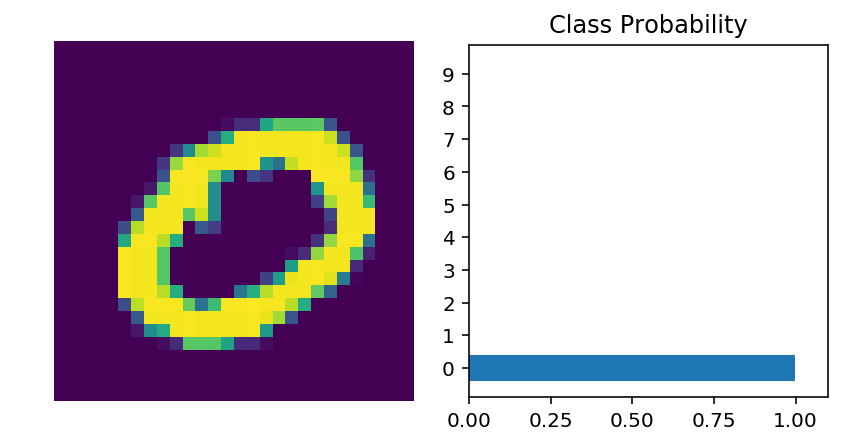

In [60]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

### Dropout and Predictions

Here we will build a model to predict fashion-MNIST. First the dataset is downloaded from `torchvision.datasets` and a transform is applied. The data is split up into train and test sets here for us to learn how to test our model on unseen data.

Recall the model building process is as follows:
- Define the entire model (all layers and activations)
- Define a loss function (usually based on the output layer's activation function)
- Define an optimizer (Adam / SGD for example)

And the model training and evaluation process:
- Train the model using `model(train_data)` and calculate the loss using `criterion(prediction, actual)`
- Find the gradients of the loss with respect to the weights (backprop) `loss.backward()`
- Use the optimizer to update the weights `optimizer.step()`
- Switch off gradients using `with torch.no_grad() :` and prepare for test evaluation


In [104]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

We will also be adding dropout to this model. The dropout rate is defined by `p`, and is the probabbility of a unit being dropped.

In [179]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # 20% probabbility we drop a unit
        self.dropout = nn.Dropout(p=0.2) 
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [106]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # combine adjascent numbers in hidden_layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])

        # iterate through layer_sizes and create layers
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        # create the output layer 
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        return F.log_softmax(x, dim=1)

Since we only want to use dropout during training, but not during testing or evaluation, we can turn dropout off by using `model.eval()` and back on when training by using `model.train()`. Everything else stays the same.

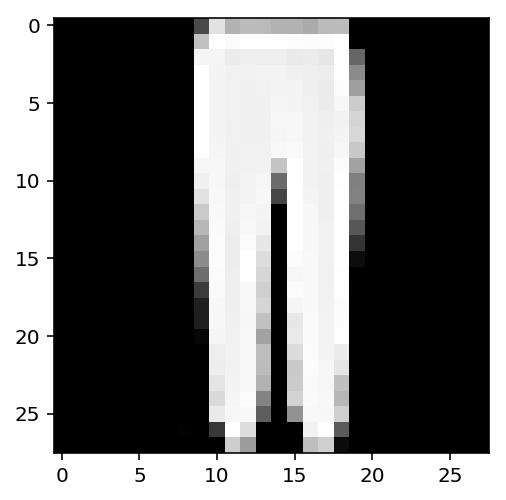

In [122]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [144]:
temp = images.resize_(images.size()[0], 784)
temp.shape

torch.Size([64, 784])

In [145]:
#model = Classifier()
model = Network(784, 10, [256, 128, 64], 0.2)

print(model)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # resize images
        _ = images.resize_(images.size()[0], 784)
        optimizer.zero_grad()
        
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # turn off gradients for validation, saves memory and computations
        with torch.no_grad() :
            _ = model.eval() # turn off dropout
            for images, labels in testloader :
                _ = images.resize_(images.size()[0], 784)
                logps = model(images)
                test_loss += criterion(logps, labels)
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        _ = model.train() # turn dropout back on 
        
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}.. ".format(accuracy/len(testloader)))

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)
Epoch: 1/30..  Training Loss: 0.602..  Test Loss: 0.460..  Test Accuracy: 0.839.. 
Epoch: 2/30..  Training Loss: 0.486..  Test Loss: 0.439..  Test Accuracy: 0.839.. 
Epoch: 3/30..  Training Loss: 0.447..  Test Loss: 0.419..  Test Accuracy: 0.847.. 
Epoch: 4/30..  Training Loss: 0.430..  Test Loss: 0.414..  Test Accuracy: 0.851.. 
Epoch: 5/30..  Training Loss: 0.423..  Test Loss: 0.419..  Test Accuracy: 0.842.. 
Epoch: 6/30..  Training Loss: 0.408..  Test Loss: 0.394..  Test Accuracy: 0.862.. 
Epoch: 7/30..  Training Loss: 0.404..  Test Loss: 0.425..  Test Accuracy: 0.849.. 
Epoch: 8/30..  Training Loss: 0.398..  Test Loss: 0.401..  Test Accuracy: 0.863.. 
Epoch: 9/30.. 

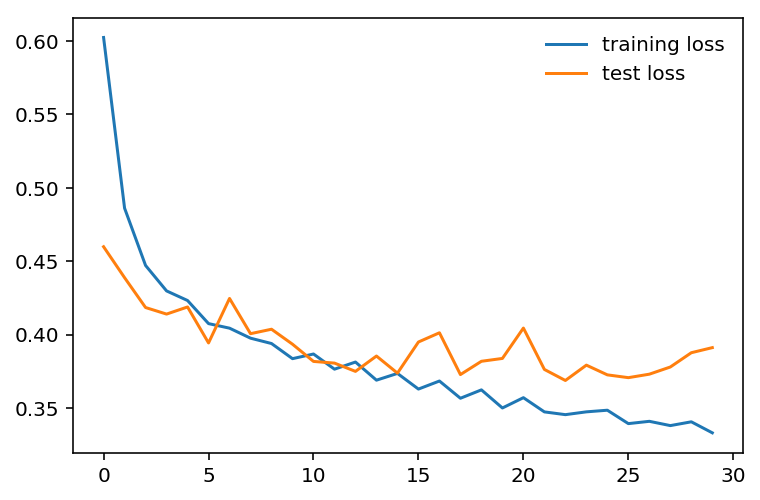

In [146]:
_ = plt.plot(train_losses, label = "training loss")
_ = plt.plot(test_losses, label = "test loss")
_ = plt.legend(frameon = False)

## Saving and Loading Models

In [147]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


We can save the state dict using `torch.save(model.state_dict(), "path")` however if we do this, we need to recreate the model with exactly the same architecture as before. 
We can build a dictionary with all the information we need to rebuild the model. Then we can load the model with `torch.load("path")`

In [148]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [149]:
# function to unpack and re-create model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [150]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)


## Downloading and Transforming Data

The easiest way to load data is with `torch.ImageFolder` from `torchvision`. In general, it is used as: `data = datasets.ImageFolder(data_dir, transform)`, where `data_dir` is a directory containing subdirecoties of the classes, for example: 
```
root/dog/xxx.png
root/dog/xxy.png

root/cat/nsdf3.png
root/cat/asd932_.png
```

### Transforms

We will also need to define transforms for our data. At the barest minimum, we have to convert the images from a pillow image to a pytorch tensor using `transforms.ToTensor()`. We can apply multiple transforms to the data using `transforms.Compose([...])`.

### Data Loader

This is the data generator, where we set the batch size and `shuffle = True` so that with every epoch, we shuffle the data. We can iterate through this by either calling `next(iter(dataloader))` or iterating over `dataloader` in a for loop.

### Data Augmentation

Here we want to add some noise to our data, so help our network generalize. We can do things like rotating images, randomly cropping or resizing images. Remember that this should only be done for our training data.

We typically also want to normalize the images with `transforms.Normalize`. Pass in a list of means and list of standard deviations, then the color channels are normalized using

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Normalizing helps keep the network weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

A list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html)

In [168]:
data_dir = 'deep-learning-v2-pytorch/intro-to-pytorch/Cat_Dog_data'

train_transforms = transforms.Compose([transforms.RandomRotation(30), # random rotation of 30deg
                                       transforms.RandomResizedCrop(224), 
                                       transforms.RandomHorizontalFlip(), # mirror horizontally
                                       transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle = True)

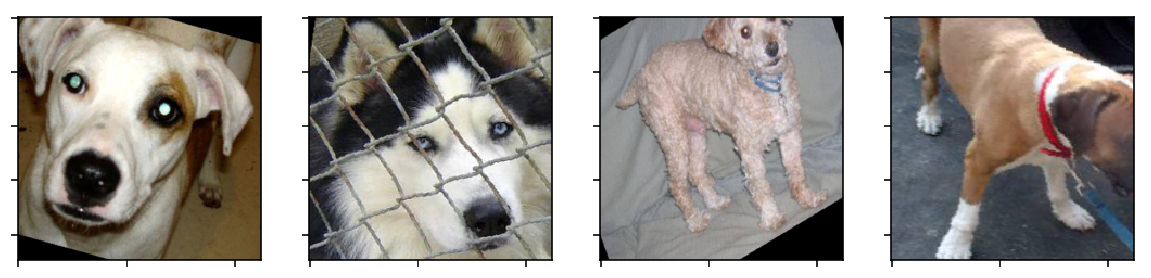

In [178]:
data_iter = iter(trainloader) # iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    image = images[ii].numpy().transpose((1, 2, 0))
    _ = ax.imshow(image)
    _ = ax.set_xticklabels('')
    _ = ax.set_yticklabels('')

## Transfer Learning

With `torchvision.models` we can use pre-trained models in our own applications. We can see the available models from torchvision [here](http://pytorch.org/docs/0.3.0/torchvision/models.html).

Most of these pretrained models require the input to be 224x224 images. We'll also need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

These models can be thought of as a feature detector, which a classifier is then be built on. To access this classifier to be able to eventually add our own, use `model.classifier`. In `densenet121`, the classifier is a single fully connected layer with `in_features = 1024` and `out_features = 1000`. This won't work for our cats and dogs example, so we have to change it.

In [194]:
densenet = models.densenet121(pretrained = True)
alexnet = models.alexnet(pretrained = True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/jonny/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:53<00:00, 4556615.51it/s] 


In [197]:
# Freeze densenet params so we dont bbackprop through them
for params in densenet.parameters() :
    params.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
    ('fc1' , nn.Linear(1024, 512)),
    ('relu1' , nn.ReLU()),
    ('fc2' , nn.Linear(512, 256)),
    ('relu2' , nn.ReLU()),
    ('fc3' , nn.Linear(256, 2)),
    ('output', nn.LogSoftmax(dim = 1))
]))

densenet.classifier = classifier

## All Imports

In [193]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F

from collections import OrderedDict

## Questions
- Can a model defined with `nn.Sequential` have dropout?
- What does `transform` do?
- What part of the NN does `model.eval()` affect? It seems to be placed in a random spot. What line of code does it HAVE to be before? `model(images)` maybe?
